In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import asapy
import numpy as np
from time import time

# Cenário: Demonstração de Navegação com Aeronave de Caça

### Descrição Geral:
Este cenário descreve um voo de navegação realizado por uma aeronave de caça, enfocando a execução de manobras em diferentes altitudes e velocidades. A navegação abrange uma variação de altitude entre Flight Level (FL) 100 e FL 350, bem como uma variação de velocidade entre 350 knots e 550 knots. Durante este voo, no terceiro ponto da rota, a aeronave realizará uma manobra de espera em torno de um ponto específico (**Hold**) durante 10 minutos, integrando-a ao padrão de voo.

<img src='./data/nav_demo.gif' width='500' height='500'>

#### Carregando Dados das Simulações

Nesta célula, estamos carregando dados de diferentes simulações a partir de arquivos CSV. Para cada cenário, existem dois tipos de arquivos:

1. Arquivos `*_aliases.csv`: Estes contêm as entradas (ou parâmetros) para cada simulação.

2. Arquivos `*_output.csv`: Estes contêm os resultados das simulações. 

Os dados são lidos e carregados em DataFrames do pandas para análise e processamento subsequentes.


In [2]:
x = pd.read_csv('./data/nav_demo_aliases.csv')
y = pd.read_csv('./data/nav_demo_output.csv')

In [3]:
preprocessing  = asapy.Preprocessing()

x = preprocessing.aliases(x)
y = preprocessing.team_metrics(y)

In [4]:
df_nav = pd.merge(x, y[['fuel_consumed']], left_index=True, right_index=True)

In [5]:
sample_nav = df_nav.sample(10)
df_nav = df_nav.loc[~df_nav.index.isin(sample_nav.index)]

In [6]:
df_nav.head(5)

,speed,altitude,fuel_consumed
experiment,,,
0,485.10,13339.30,1460.593196
1,518.46,34516.34,883.070714
2,501.61,23487.75,1063.105283
3,525.65,16748.43,1400.689116
4,438.32,21489.87,1051.047824


## EXPERIMENTO 1: Previsão do Consumo de Combustível na rota específica

#### Rede Neural

In [7]:
start_time_1 = time()

In [8]:
nn_nav = asapy.NeuralNetwork(target="fuel_consumed", name='demo_nn_nav', seed=25)

In [9]:
nn_nav.build(
    df_nav,
    task="regression",
    max_cat_nunique = 10,
    split_size = (0.7, 0.15, 0.15),
    info=True,
    patience_early_stopping = 20,
    patience_reduceLR = 4,
    metrics=['rmse']
)


                Task: regression

                Total of registers: 3990
                Total of valid registers: 3990
                Total of invalid registers: 0

                Total of training registers: 2792
                Total of validation registers: 599
                Total of test registers: 599

                Features before preprocessing: 2
                Features after preprocessing: 2

                Numerical Features: ['speed', 'altitude']
                Categorical Features: []
                Categorical Features removed due to high cardinality: []

                Target: ['fuel_consumed']
            


In [10]:
nn_nav.hyperparameter_optimization(
    n_trials=18,
    num_folds=4,
    info=True,
    search_space_dropout = [0.0, 0.5],
    search_space_layers = [2, 3, 4],
    search_space_batch_size = [32, 64, 128],
    search_space_optimizer = ['Adam']
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


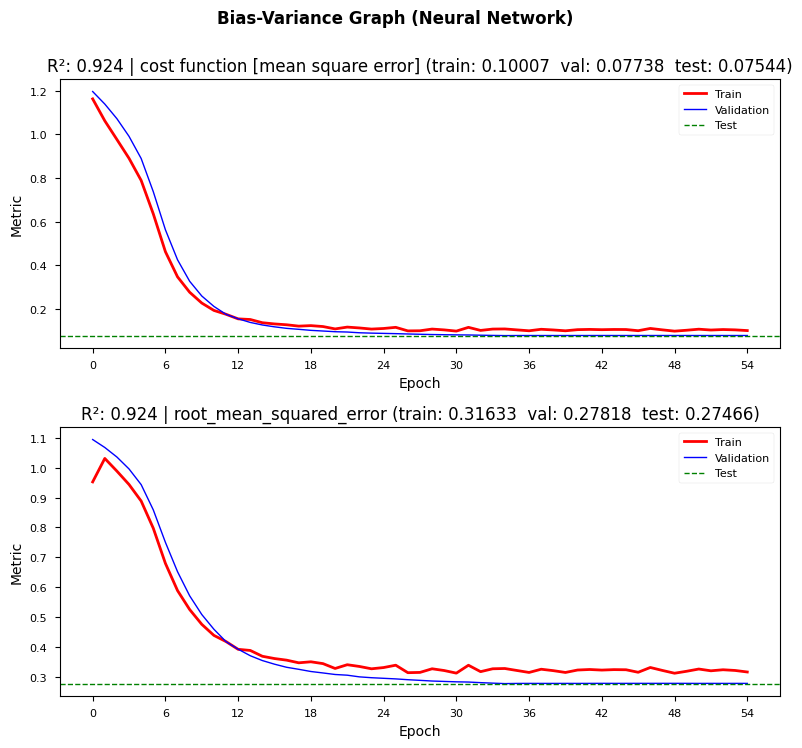

In [11]:
nn_nav.fit(return_history=False, graph=True, graph_save_extension='eps', verbose=0)

In [12]:
end_time_1 = time()

In [13]:
start_time_2 = time()

In [14]:
pred_nn_nav = nn_nav.predict(sample_nav, verbose=0)

Inference time: 64.73 milliseconds (10 register(s))


In [15]:
pred_nn_nav

,speed,altitude,fuel_consumed,fuel_consumed (NN prediction)
experiment,,,,
2095,541.02,13585.37,1639.759434,1576.993042
2178,497.53,22000.20,1100.405010,1104.188110
3940,514.63,30697.13,899.245839,981.392090
2721,534.86,25871.43,1063.957112,1059.874756
2862,459.70,14050.65,1332.035935,1340.390381
1145,431.84,19806.68,1060.409220,1029.693848
3460,503.80,33866.40,892.656692,981.392090
1476,482.20,26681.29,944.881064,981.392090
3215,546.34,12517.10,1726.681532,1633.573853


In [16]:
end_time_2 = time()

In [17]:
print(f"Tempo de Treinamento: {end_time_1 - start_time_1}")

Tempo de Treinamento: 1191.1559476852417


In [18]:
print(f"Tempo de Inferência: {end_time_2 - start_time_2}")

Tempo de Inferência: 0.09801912307739258


#### XG Boost

In [19]:
start_time_3 = time()

In [20]:
xgb_nav = asapy.XgBoost(target="fuel_consumed", name='demo_xgb_nav', seed=25)

In [21]:
xgb_nav.build(
    df_nav,
    task="regression",
    num_folds=5,
    max_cat_nunique = 10,
    split_size = (0.7, 0.15, 0.15),
    info=True,
    patience_early_stopping = 20,
    metrics=['mse']
)


                Task: regression

                Total of registers: 3990
                Total of valid registers: 3990
                Total of invalid registers: 0

                Total of training registers: 2792
                Total of validation registers: 599
                Total of test registers: 599

                Features before preprocessing: 2
                Features after preprocessing: 2

                Numerical Features: ['speed', 'altitude']
                Categorical Features: []
                Categorical Features removed due to high cardinality: []

                Target: ['fuel_consumed']
            


In [22]:
xgb_nav.hyperparameter_optimization(
    n_trials=10,
    num_folds = 5, 
    info=True,
    search_space_tree_method = ['auto'],
    search_space_booster = ['gbtree', 'gblinear', 'dart'],
    search_space_learning_rate = [0.3],
    search_space_min_split_loss = [0],
    search_space_max_depth = [6],
    search_space_min_child_weight = [1],
    search_space_max_delta_step = [0],
    search_space_subsample = [1],
    search_space_sampling_method = ['uniform'],
    search_space_colsample_bytree = [1],
    search_space_colsample_bylevel = [1],
    search_space_colsample_bynode = [1],
    search_space_reg_lambda = [1],
    search_space_reg_alpha = [0],
    search_space_scale_pos_weight = [1],
    search_space_grow_policy = ['depthwise'],
    search_space_max_leaves = [0],
    search_space_max_bin = [256],
    search_space_num_parallel_tree = [1]
)

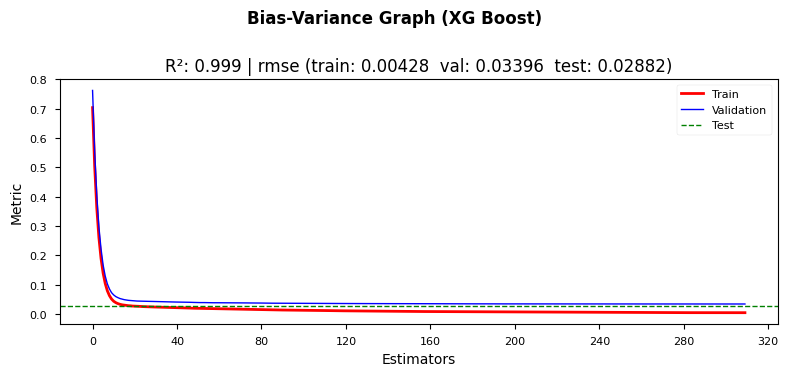

In [23]:
history_xgb_nav = xgb_nav.fit(return_history=True, graph=True, graph_save_extension='png', verbose=0)

In [24]:
end_time_3 = time()

In [25]:
start_time_4 = time()

In [26]:
pred_xgb_nav = xgb_nav.predict(sample_nav)

Inference time: 3.97 milliseconds (10 register(s))


In [27]:
pred_xgb_nav

,speed,altitude,fuel_consumed,fuel_consumed (XGB prediction)
experiment,,,,
2095,541.02,13585.37,1639.759434,1628.821533
2178,497.53,22000.20,1100.405010,1102.583740
3940,514.63,30697.13,899.245839,900.230774
2721,534.86,25871.43,1063.957112,1073.241089
2862,459.70,14050.65,1332.035935,1328.920410
1145,431.84,19806.68,1060.409220,1057.730591
3460,503.80,33866.40,892.656692,892.082520
1476,482.20,26681.29,944.881064,938.928711
3215,546.34,12517.10,1726.681532,1699.698608


In [28]:
end_time_4 = time()

In [29]:
print(f"Tempo de Treinamento: {end_time_3 - start_time_3}")

Tempo de Treinamento: 135.82926893234253


In [30]:
print(f"Tempo de Inferência: {end_time_4 - start_time_4}")

Tempo de Inferência: 0.03572797775268555


## EXPERIMENTO 2: Segmentação de classe de Combustível na rota específica

#### KMeans

In [31]:
start_time_5 = time()

In [32]:
kmeans_nav = asapy.KMeans(name='demo_kmeans_nav', seed=25)

In [33]:
kmeans_nav.build(df_nav, info=True)


                Total of registers: 3990
                Total of valid registers: 3990
                Total of invalid registers: 0

                Total of Features: 3
                Numerical Features: ['speed', 'altitude', 'fuel_consumed']
                Categorical Features: []
                Categorical Features removed due to high cardinality: []
            


In [34]:
kmeans_nav.hyperparameter_optimization(
    n_trials=10,
    info=True,
    search_space_n_clusters=[4],
    search_space_init  = ['k-means++'],
    search_space_n_init = ['auto'],
    search_space_tol = [1e-5, 1e-4, 1e-3],
    search_space_algorithm = ['lloyd', 'elkan']
)

,Trial (nº),Silhouette Score,params_algorithm,params_init,params_n_clusters,params_n_init,params_tol
Ranking,,,,,,,
1º,0,0.394567,lloyd,k-means++,4,auto,0.00100
2º,9,0.394567,elkan,k-means++,4,auto,0.00100
3º,2,0.394558,elkan,k-means++,4,auto,0.00001
4º,3,0.394558,elkan,k-means++,4,auto,0.00001
5º,5,0.394558,lloyd,k-means++,4,auto,0.00001
6º,6,0.394558,elkan,k-means++,4,auto,0.00001
7º,8,0.394558,lloyd,k-means++,4,auto,0.00001
8º,1,0.394552,lloyd,k-means++,4,auto,0.00010
9º,4,0.394552,lloyd,k-means++,4,auto,0.00010


In [35]:
clusters = kmeans_nav.fit(return_cluster=True)

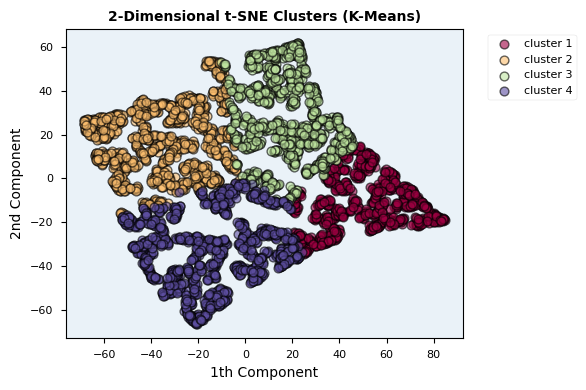

In [36]:
kmeans_nav.predict(projection='2d', graph_save_extension='png')

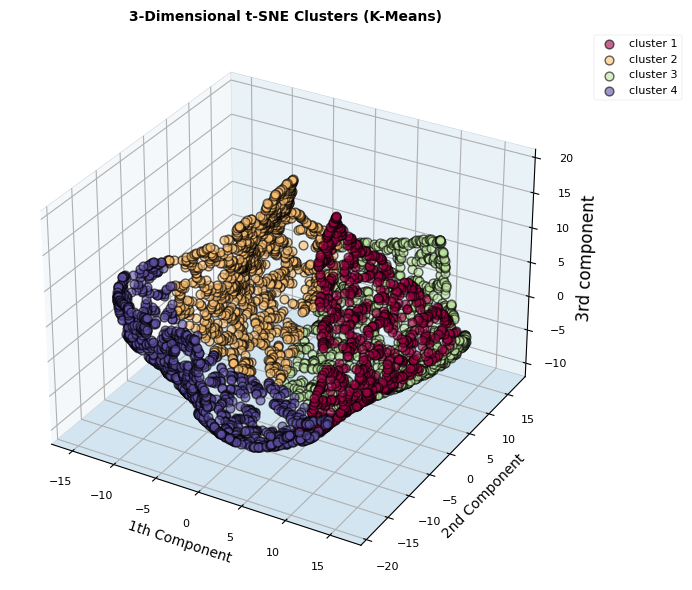

In [37]:
kmeans_nav.predict(projection='3d', graph_save_extension='png')

In [38]:
end_time_5 = time()

In [39]:
print(f"Tempo de Treinamento: {end_time_5 - start_time_5}")

Tempo de Treinamento: 43.65243864059448


## EXPERIMENTO 3: Previsão da classe de Consumo de Combustível na rota específica

#### Data leak intencional, com o intuito de criar um Case de classificação. Asuma que a nfomação do cluster seja obtida de observação factual

In [40]:
df_nav_class = df_nav.copy()
df_nav_class['Cluster'] = clusters

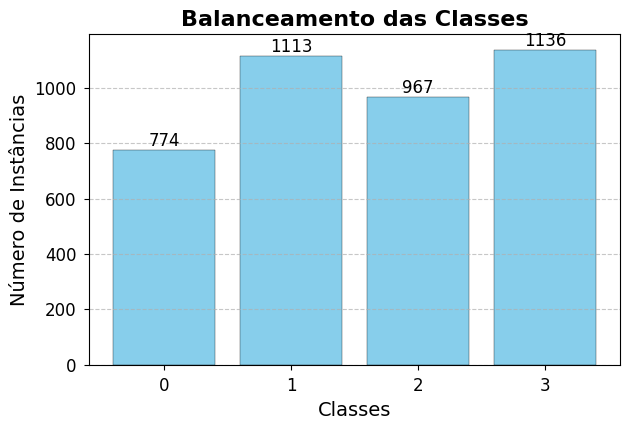

In [41]:
# plt.style.use('seaborn-darkgrid')  # Usa um estilo de fundo do Seaborn
# plt.figure(figsize=(10, 6))  # Tamanho do gráfico

class_counts = df_nav_class['Cluster'].value_counts().sort_index()

bars = plt.bar(class_counts.index, class_counts.values, color='skyblue', edgecolor='black')

plt.title('Balanceamento das Classes', fontsize=16, fontweight='bold')
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Número de Instâncias', fontsize=14)

plt.xticks(class_counts.index, fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

In [42]:
# !pip install imblearn

In [43]:
from imblearn.over_sampling import SMOTE
from collections import Counter

sm = SMOTE(random_state=42)
X = df_nav_class.drop('Cluster', axis=1)
y = df_nav_class['Cluster']

X_res, y_res = sm.fit_resample(X, y)

# Se precisar, converta de volta para DataFrame pandas
df_nav_class = pd.DataFrame(X_res, columns=X.columns)
df_nav_class['Cluster'] = y_res

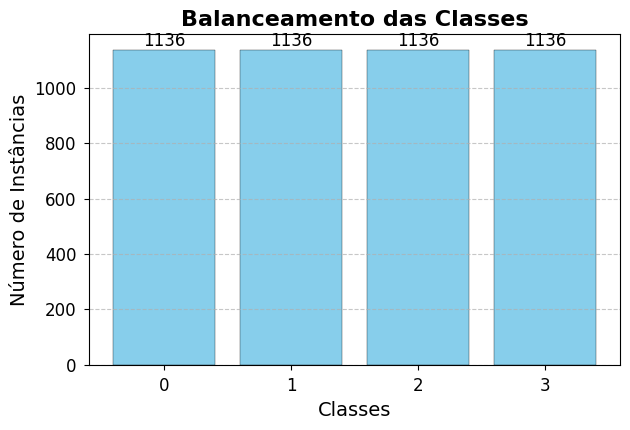

In [44]:
# plt.style.use('seaborn-darkgrid')  # Usa um estilo de fundo do Seaborn
# plt.figure(figsize=(10, 6))  # Tamanho do gráfico

class_counts = df_nav_class['Cluster'].value_counts().sort_index()

bars = plt.bar(class_counts.index, class_counts.values, color='skyblue', edgecolor='black')

plt.title('Balanceamento das Classes', fontsize=16, fontweight='bold')
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Número de Instâncias', fontsize=14)

plt.xticks(class_counts.index, fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

In [45]:
sample_nav_class = df_nav_class.sample(10)
df_nav_class = df_nav_class.loc[~df_nav_class.index.isin(sample_nav_class.index)]

#### Rede Neural

In [46]:
start_time_6 = time()

In [47]:
nn_nav_class = asapy.NeuralNetwork(target="Cluster", name='demo_nn_nav_class', seed=25)

In [48]:
nn_nav_class.build(
    df_nav_class,
    task='classification',
    max_cat_nunique = 10,
    split_size = (0.7, 0.15, 0.15),
    info=True,
    patience_early_stopping = 20,
    patience_reduceLR = 4,
    metrics=['auc', 'precision', 'recall', 'accuracy'] 
)


                Task: classification

                Total of registers: 4534
                Total of valid registers: 4534
                Total of invalid registers: 0

                Total of training registers: 3173
                Total of validation registers: 681
                Total of test registers: 680

                Features before preprocessing: 3
                Features after preprocessing: 3

                Numerical Features: ['speed', 'altitude', 'fuel_consumed']
                Categorical Features: []
                Categorical Features removed due to high cardinality: []

                Target: ['Cluster']
            	Cardinality (Target): 4


In [49]:
nn_nav_class.hyperparameter_optimization(
    n_trials=10,
    num_folds=5,
    info=True,
    search_space_dropout = [0.0, 0.5],
    search_space_layers = [2, 3, 4],
    search_space_batch_size = [32, 64],
    search_space_optimizer = ['Adam']
)

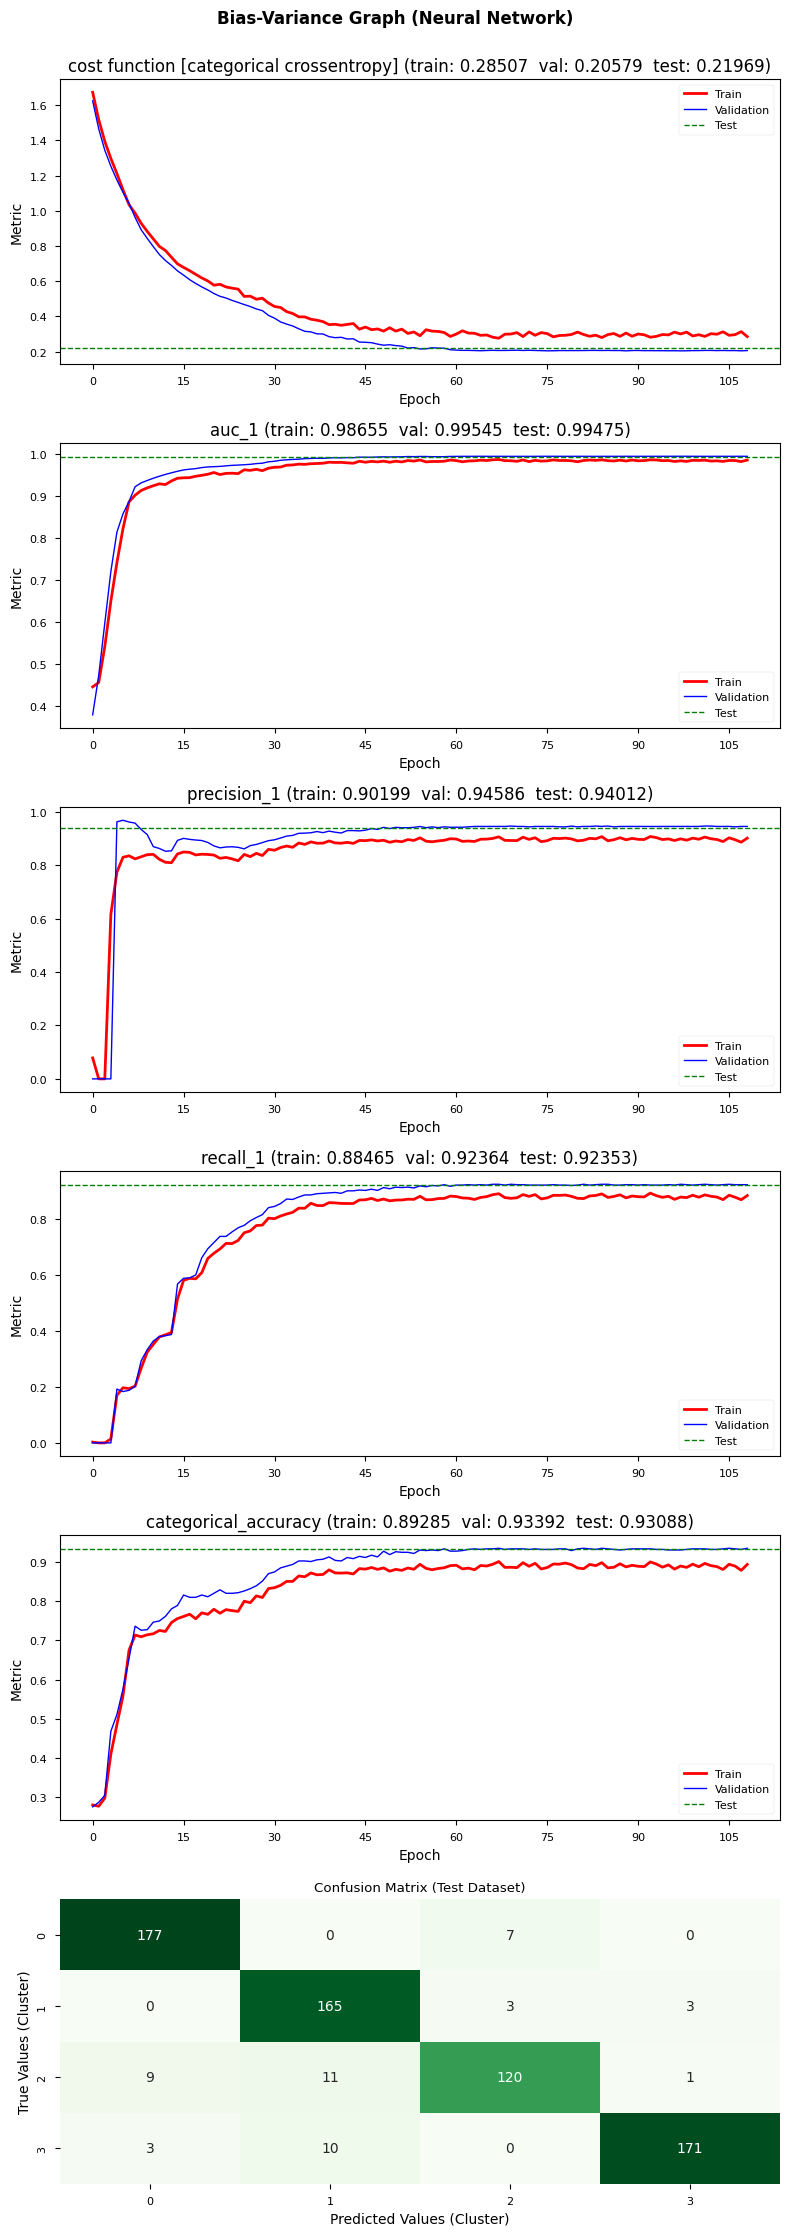

In [50]:
history_nn_nav_class = nn_nav_class.fit(return_history=True, graph=True, graph_save_extension='png', verbose=0)

In [51]:
end_time_6 = time()

In [52]:
start_time_7 = time()

In [53]:
pred_nn_nav_class = nn_nav_class.predict(sample_nav_class, verbose=0)

Inference time: 58.86 milliseconds (10 register(s))


In [54]:
pred_nn_nav_class

,speed,altitude,fuel_consumed,Cluster,Cluster (NN prediction)
1188,399.570000,24351.950000,1000.094982,1,1
3822,370.450000,14208.570000,1111.765185,2,2
4024,547.922361,16288.834990,1524.187729,0,0
2186,436.270000,30288.860000,922.637352,1,1
1184,383.870000,11497.020000,1134.392941,2,2
2142,455.820000,34017.300000,901.054288,3,3
4124,504.616749,17957.611481,1271.960258,0,0
2919,476.130000,30465.260000,862.449214,3,3
326,377.150000,29061.710000,974.237762,1,1
1158,475.930000,32693.750000,881.627991,3,3


In [55]:
end_time_7 = time()

In [56]:
print(f"Tempo de Treinamento: {end_time_6 - start_time_6}")

Tempo de Treinamento: 1079.277629852295


In [57]:
print(f"Tempo de Inferência: {end_time_7 - start_time_7}")

Tempo de Inferência: 0.0919027328491211


#### XG Boost

In [58]:
start_time_8 = time()

In [59]:
xgb_nav_class = asapy.XgBoost(target="Cluster", name='demo_xgb_nav_class', seed=25)

In [60]:
xgb_nav_class.build(
    df_nav_class,
    task='classification',
    max_cat_nunique = 10,
    split_size = (0.7, 0.15, 0.15),
    info=True,
    patience_early_stopping = 20
)


                Task: classification

                Total of registers: 4534
                Total of valid registers: 4534
                Total of invalid registers: 0

                Total of training registers: 3173
                Total of validation registers: 681
                Total of test registers: 680

                Features before preprocessing: 3
                Features after preprocessing: 3

                Numerical Features: ['speed', 'altitude', 'fuel_consumed']
                Categorical Features: []
                Categorical Features removed due to high cardinality: []

                Target: ['Cluster']
            	Cardinality (Target): 4


In [61]:
xgb_nav_class.hyperparameter_optimization(
    n_trials=10,
    num_folds=5,
    info=True,
    search_space_tree_method = ['auto'],
    search_space_booster = ['gbtree', 'gblinear', 'dart'],
    search_space_learning_rate = [0.2, 0.3],
    search_space_min_split_loss = [0],
    search_space_max_depth = [5, 6, 7],
    search_space_min_child_weight = [1],
    search_space_max_delta_step = [0],
    search_space_subsample = [1],
    search_space_sampling_method = ['uniform'],
    search_space_colsample_bytree = [1],
    search_space_colsample_bylevel = [1],
    search_space_colsample_bynode = [1],
    search_space_reg_lambda = [1],
    search_space_reg_alpha = [0],
    search_space_scale_pos_weight = [1],
    search_space_grow_policy = ['depthwise'],
    search_space_max_leaves = [0],
    search_space_max_bin = [256, 512],
    search_space_num_parallel_tree = [1]
)

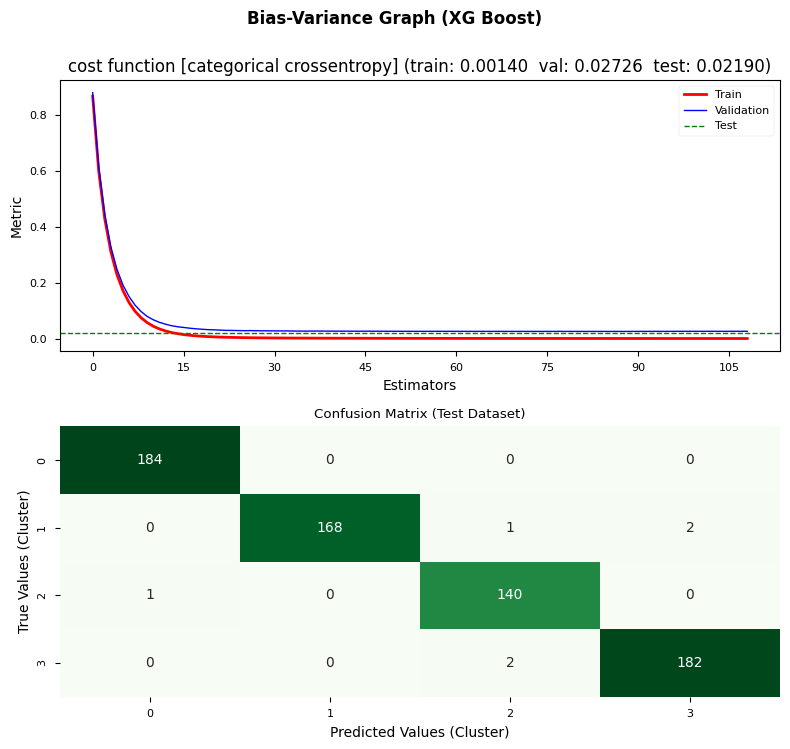

In [62]:
history_xgb_nav_class = xgb_nav_class.fit(return_history=True, graph=True, graph_save_extension='png', verbose=0)

In [63]:
end_time_8 = time()

In [64]:
start_time_9 = time()

In [65]:
pred_xgb_nav_class = xgb_nav_class.predict(sample_nav_class)

Inference time: 8.71 milliseconds (10 register(s))


In [66]:
pred_xgb_nav_class

,speed,altitude,fuel_consumed,Cluster,Cluster (XGB prediction)
1188,399.570000,24351.950000,1000.094982,1,1
3822,370.450000,14208.570000,1111.765185,2,2
4024,547.922361,16288.834990,1524.187729,0,0
2186,436.270000,30288.860000,922.637352,1,1
1184,383.870000,11497.020000,1134.392941,2,2
2142,455.820000,34017.300000,901.054288,3,3
4124,504.616749,17957.611481,1271.960258,0,0
2919,476.130000,30465.260000,862.449214,3,3
326,377.150000,29061.710000,974.237762,1,1
1158,475.930000,32693.750000,881.627991,3,3


In [67]:
end_time_9 = time()

In [68]:
print(f"Tempo de Treinamento: {end_time_8 - start_time_8}")

Tempo de Treinamento: 251.73658561706543


In [69]:
print(f"Tempo de Inferência: {end_time_9 - start_time_9}")

Tempo de Inferência: 0.04130053520202637
